# TASK 3

Please write a simple compiler – program, which translates one quantum circuit into another, using a restricted set of gates.

You need to consider just the basic gates for the input circuit, such as (I, H, X, Y, Z, RX, RY, RZ, CNOT, CZ).

The output circuit should consist only from the following gates: RX, RZ, CZ. In other words, each gate in the original circuit must be replaced by an equivalent combination of gates coming from the restricted set (RX, RZ, CZ) only.

For example, a Hadamard gate after compilation looks like this:

RX(pi/2)RZ(pi/2)

Analyze what’s the overhead of the compiled program compared to the original one and propose how to improve it. What we mean by overhead is the following: by replacing all the initial gates with the restricted set of gates given in the problem, you will see that the resulting circuit is much more involved than the original one. This is what we called the overhead, and you may think how to treat this problem, i.e. you could try to simplify as much as possible the resulting circuit.

In [1]:
# Import dependencies
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
import qiskit.quantum_info as qi

## Contents

1. [Approach](#approach)  
2. [Implementation](#implementation)    
    2.1 [Example 1](#ex1)    
    2.2 [Example 2](#ex2)    
3. [Analyzing Overhead](#overhead)    
4. [Optimization - Level 1](#op1)    
    4.1 [Example 3](#ex3)
5. [Optimization - Level 2](#op2)    
    5.1 [Example 4](#ex4)
6. [Optimization - Level 3](#op3)
7. [Final Notes](#final)       

## 1. Approach <a id="approach"></a>

The compiler was implemented using Qiskit. All the gate translations and circuit optimizations for cost reduction were implemented from scratch **without** relying or reusing any of the code from Qiskit's [`PassManager`](https://qiskit.org/documentation/stubs/qiskit.transpiler.PassManager.html) or [`transpile`](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) functions.

Below are the equivalencies used for each of the input gates onto the basis gates.

### X-Rotation Gates

X-rotation gates $R_X(\theta)$ are part of the basis gates, so they are translated one-to-one. These gates have the following unitary:

$
R_X(\theta) = \begin{bmatrix} \cos \left (\frac{\theta}{2} \right) & -i \sin \left (\frac{\theta}{2} \right) \\ -i \sin \left (\frac{\theta}{2} \right) & \cos \left (\frac{\theta}{2} \right) \end{bmatrix}
$


### Z-Rotation Gates

Z-rotation gates $R_Z(\phi)$ are part of the basis gates, so they are translated one-to-one. These gates have the following unitary:

$
R_Z(\phi) = \begin{bmatrix} e^{-i\frac{\phi}{2}} & 0 \\ 0 & e^{i\frac{\phi}{2}} \end{bmatrix}
$


### Y-Rotation Gates

Y-rotation gates $R_Y(\theta)$ are implemented by doing a change in the axis of rotation. First, a rotation of $\frac{\pi}{2}$ about the X axis "exchanges" the Y axis with the Z axis. Then a rotation of $\theta$ about the Z axis performs the desired rotation. Lastly, a a rotation of $-\frac{\pi}{2}$ about the X axis returns the axes to the original place:

$
\begin{align}
R_Y(\theta) &= R_X(-\pi/2) R_Z(\theta) R_X(\pi/2) 
\\
\\
&= \begin{bmatrix} \frac{1}{\sqrt{2}} & \frac{i}{\sqrt{2}} \\ \frac{i}{\sqrt{2}} & \frac{1}{\sqrt{2}} \end{bmatrix} \begin{bmatrix} e^{-i\frac{\theta}{2}} & 0 \\ 0 & e^{i\frac{\theta}{2}} \end{bmatrix} \begin{bmatrix} \frac{1}{\sqrt{2}} & -\frac{i}{\sqrt{2}} \\ -\frac{i}{\sqrt{2}} & \frac{1}{\sqrt{2}} \end{bmatrix}
\\
\\
&= \begin{bmatrix} \cos \left (\frac{\theta}{2} \right) & - \sin \left (\frac{\theta}{2} \right) \\  \sin \left (\frac{\theta}{2} \right) & \cos \left (\frac{\theta}{2} \right) \end{bmatrix}
\end{align}
$


### Indentity Gates

The identity gate was translated onto $R_Z$ gates with a rotation angle of 0 radians:

$
\begin{align}
I &= R_Z(0) 
\\
\\
&= \begin{bmatrix} e^{-i\frac{0}{2}} & 0 \\ 0 & e^{i\frac{0}{2}} \end{bmatrix} 
\\
\\
&= \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
\end{align}
$

However, these gates can be removed all together if necessary.

### Pauli-X Gates

X Pauli gate can be implemented by applying an $R_X$ with a rotation of $\pi$ radians, and a global phase of i:

$
\begin{align}
X &= i R_X(\pi)
\\
\\
&= i\begin{bmatrix} \cos \left (\frac{\pi}{2} \right) & -i \sin \left (\frac{\pi}{2} \right) \\ -i \sin \left (\frac{\pi}{2} \right) & \cos \left (\frac{\pi}{2} \right) \end{bmatrix}
\\
\\
&= \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} 
\end{align}
$


### Pauli-Z Gates

Z Pauli gate can be implemented by applying an $R_Z$ with a rotation of $\pi$ radians, and a global phase of i:

$
\begin{align}
Z &= i R_Z(\pi)
\\
\\
&= i \begin{bmatrix} e^{-i\frac{\pi}{2}} & 0 \\ 0 & e^{i\frac{\pi}{2}} \end{bmatrix}
\\
\\
&= \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} 
\end{align}
$


### Pauli-Y Gates

Y Pauli gate can be implemented by a sequence of Z and X gates, and a global phase of i. 

$ Y = -iXZ $

As shown before, Z and X can be expressed in terms of $R_Z(\pi)$ and $R_X(\pi)$, respectively:

$
\begin{align}
Y &= -i (i R_X(\pi)) (i R_Z(\pi))
\\
\\
&= i \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} 
\\
\\
&= \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} 
\end{align}
$


### Hadamard Gates

Hadamard gates consist of rotation of $\pi/2$ degrees about the Z axis, followed by a rotation of $\pi/2$ about the X axis, then a second rotation of $\pi/2$ degrees about the Z axis, and a global phase of i:

$
\begin{align}
H &= i R_Z(\pi/2) R_X(\pi/2) R_Z(\pi/2)
\\
\\
&= i \begin{bmatrix} e^{-i\frac{\pi}{4}} & 0 \\ 0 & e^{i\frac{\pi}{4}} \end{bmatrix} \begin{bmatrix} \cos \left (\frac{\pi}{4} \right) & - \sin \left (\frac{\pi}{4} \right) \\  \sin \left (\frac{\pi}{4} \right) & \cos \left (\frac{\pi}{4} \right) \end{bmatrix} \begin{bmatrix} e^{-i\frac{\pi}{4}} & 0 \\ 0 & e^{i\frac{\pi}{4}} \end{bmatrix} 
\\
\\
&= \begin{bmatrix} \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \end{bmatrix} 
\end{align}
$

### Controlled-Z Gates

Controlled-Z gates $CZ$ are part of the basis gates, so they are translated one-to-one. These gates have the following unitary:

$
CZ = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\  0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} 
$

### Controlled-X Gates

Controlled-X gates $CX$ can be translated into $CZ$ gates by performing a change in basis using the following [equivalency](https://arxiv.org/pdf/1110.2998):


<img src=".\images\CX_to_CZ.png" width="350"/>

where, as before, the H gates can be implemented using $R_X$ and $R_Z$ rotations.

## 2. Implementation (No Optimization) <a id="implementation"></a>

The code below performs the gate mapping described in the section above. No optimization for overhead reduction was applied.

In [2]:
def translate0(qc_ori, trans_id = True, keep_H = False):

    """Define new circuit of same # of qubits as circuit passed (no classical bits, but can be added):"""
    qc_trans = QuantumCircuit(qc_ori.num_qubits)
    
    """Loop through all gates of original circuit and translate into basis gates: rx, rz, cz"""
    for i in range(len(qc_ori.data)):
        if type(qc_ori.data[i][0]).__name__ == 'RXGate':
            """RX is left unchanged. Rotation angle for RX gate is extracted from original circuit
               using .params method"""
            ind = qc_ori.data[i][1][0].index
            theta = qc_ori.data[i][0].params[0]
            qc_trans.rx(theta,ind)

        elif type(qc_ori.data[i][0]).__name__ == 'RZGate':
            """RZ is left unchanged. Rotation angle for RZ gate is extracted from original circuit
               using .params method"""
            ind = qc_ori.data[i][1][0].index
            phi = qc_ori.data[i][0].params[0]
            qc_trans.rz(phi,ind)
            
        elif type(qc_ori.data[i][0]).__name__ == 'RYGate':
            """RY is implemented using sequence of RX and RZ rotations as shown in the description above"""
            ind = qc_ori.data[i][1][0].index
            theta = qc_ori.data[i][0].params[0]
            qc_trans.rx(np.pi/2,ind)
            qc_trans.rz(theta,ind)
            qc_trans.rx(-np.pi/2,ind)
            
        elif type(qc_ori.data[i][0]).__name__ == 'IGate':
            """I is implemented as 0 rad z-rotation if trans_id is true. Otherwise, I is ignored"""
            if trans_id == True:
                ind = qc_ori.data[i][1][0].index
                theta = 0
                qc_trans.rz(theta,ind)

        elif type(qc_ori.data[i][0]).__name__ == 'XGate':
            """X is implemented by a pi rotation about the X axis"""
            ind = qc_ori.data[i][1][0].index
            theta = np.pi
            qc_trans.rx(theta,ind)
            
        elif type(qc_ori.data[i][0]).__name__ == 'ZGate':
            """Z is implemented by a pi rotation about the Z axis"""
            ind = qc_ori.data[i][1][0].index
            phi = np.pi
            qc_trans.rz(phi,ind)  

        elif type(qc_ori.data[i][0]).__name__ == 'YGate':
            """Y is implemented by a pi rotation about the Y axis"""
            ind = qc_ori.data[i][1][0].index
            theta = np.pi
            qc_trans.rx(np.pi/2,ind)
            qc_trans.rz(theta,ind)
            qc_trans.rx(-np.pi/2,ind)            
                  
        elif type(qc_ori.data[i][0]).__name__ == 'HGate':
            """H implemented as pi/2 rad z-rotation followed by  pi/2 rad x-rotation"""
            ind = qc_ori.data[i][1][0].index
            
            if keep_H:
                """If True, H gates are not translated into Rx, Rz basis"""
                qc_trans.h(ind)
            else:
                qc_trans.rz(np.pi/2,ind)
                qc_trans.rx(np.pi/2,ind)
                qc_trans.rz(np.pi/2,ind)

        elif type(qc_ori.data[i][0]).__name__ == 'CZGate':
            """CZ is left unchanged."""
            ind0 = qc_ori.data[i][1][0].index
            ind1 = qc_ori.data[i][1][1].index
            qc_trans.cz(ind0,ind1)            

        elif type(qc_ori.data[i][0]).__name__ == 'CXGate':
            """CX is replace by a CZ and Hadamard gates before and after CZ on the target qubit."""
            ind0 = qc_ori.data[i][1][0].index
            ind1 = qc_ori.data[i][1][1].index
            
            if keep_H:
                """If True, H gates are not translated into Rx, Rz basis"""
                qc_trans.h(ind1)
                qc_trans.cz(ind0,ind1)
                qc_trans.h(ind1)
            else:
                qc_trans.rz(np.pi/2,ind1)
                qc_trans.rx(np.pi/2,ind1)
                qc_trans.rz(np.pi/2,ind1)
                qc_trans.cz(ind0,ind1)              
                qc_trans.rz(np.pi/2,ind1)
                qc_trans.rx(np.pi/2,ind1)
                qc_trans.rz(np.pi/2,ind1)
            
        else:
            name = type(qc_ori.data[i][0]).__name__
            raise Exception('Circuit contains the unsupported gate: {}'.format(name))
            break
            
    return qc_trans

### Example 1  <a id="ex1"></a>

To verify if the compiler is working properly, let's first check an example with single-qubit gates

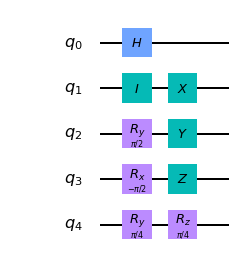

In [3]:
qc1 = QuantumCircuit(5)
qc1.h(0)
qc1.i(1)
qc1.x(1)
qc1.ry(np.pi/2,2)
qc1.y(2)
qc1.rx(-np.pi/2,3)
qc1.z(3)
qc1.ry(np.pi/4,4)
qc1.rz(np.pi/4,4)
qc1.draw(output='mpl')

Let's now compile the circuit by passing it to our `translate0` function:

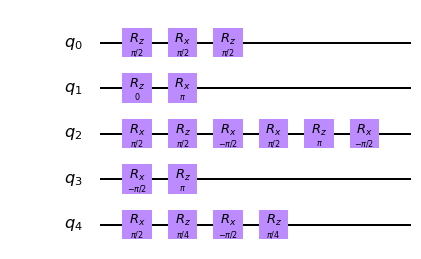

In [4]:
qc1_trans = translate0(qc1)
qc1_trans.draw(output='mpl')

Since we are using single qubit gates only, we can compare the Bloch Sphere representations of the output states generated by these two circuits to make sure they are equivalent:

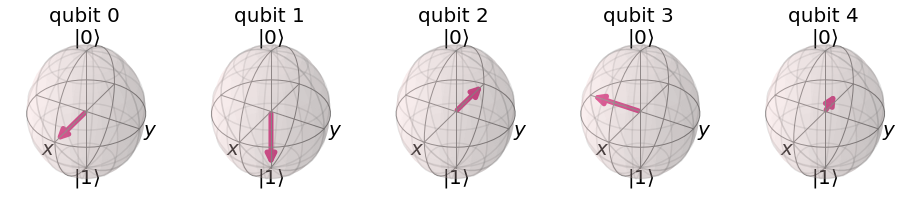

In [5]:
# Bloch sphere representation of original circuit
plot_bloch_multivector(qi.Statevector.from_instruction(qc1).data)

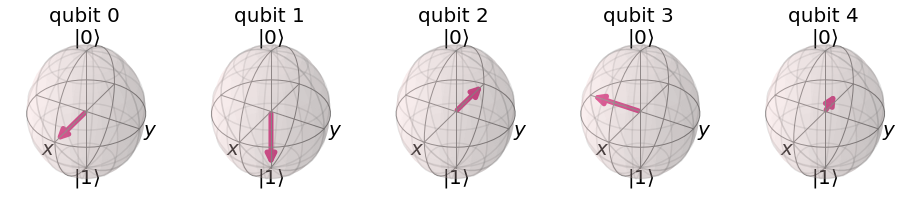

In [6]:
# Bloch sphere representation of compiled circuit
plot_bloch_multivector(qi.Statevector.from_instruction(qc1_trans).data)

We can see that the resulting statevector for the two circuits is the same.

### Example 2  <a id="ex2"></a>

Let's now check a circuit with two qubit gates. For this example we use a 4 qubit GHZ circuit followed by Hadamard sampling:

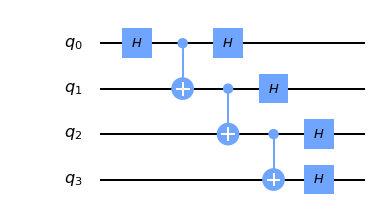

In [7]:
qc2 = QuantumCircuit(4)
qc2.h(0)
qc2.cx([0,1,2],[1,2,3])
qc2.h(range(4))
qc2.draw('mpl')

Let's now compiler the circuit by passing it to our `translate0` function:

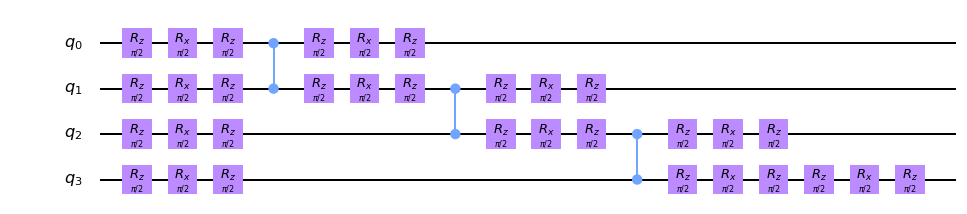

In [8]:
qc2_trans = translate0(qc2)
qc2_trans.draw(output='mpl')

We can verify if these two circuits are equivalent by looking at the Qsphere representation of their outpu states:

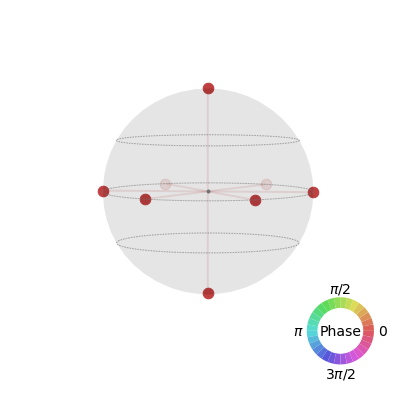

In [9]:
# Qsphere representation of original circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc2).data)

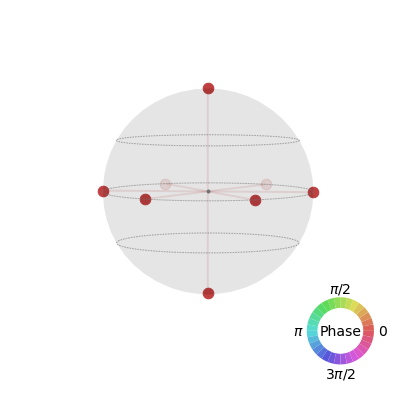

In [10]:
# Qsphere representation of compiled circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc2_trans).data)

As expected, the resulting statevectors match.

## 3. Analyzing Overhead  <a id="overhead"></a>

To analyze overhead, we define the following cost function:

$ c = 5 n_2 + n_1, $

where $n_2$ is the number of 2 qubit gates, and $n_1$ is the number of single qubit gates. We have included a 5x multiplier for 2 qubit gates since these usually have higher error rates, but for the purpose of this task this might be irrelevant since we will be only comparing relative values between different optimization levels.

In [11]:
def qc_cost(qc):
    gates = qc.count_ops()
    cost = 0
    for key in gates:
        if (key == 'cx') or (key == 'cz'):
            cost += 5*gates[key]
        else:
            cost += gates[key]
    return cost

For our first example, we can see that our cost doubles. This is because gates that require rotations about the y axis (like Hadamard gates) add 2 additional gates to perform a change in the axis of rotation.

In [12]:
cost_ori = qc_cost(qc1)
cost_trans =  qc_cost(qc1_trans)
overhead = cost_trans - cost_ori
print('Cost of original circuit: {}'.format(cost_ori))
print('Cost of compiled circuit: {}'.format(cost_trans))
print('Overhead: {}'.format(overhead))

Cost of original circuit: 9
Cost of compiled circuit: 17
Overhead: 8


Similarly, we see a large increase in overhead for the second example due to the large number of Hadamard gates used:

In [13]:
cost_ori = qc_cost(qc2)
cost_trans =  qc_cost(qc2_trans)
overhead = cost_trans - cost_ori
print('Cost of original circuit: {}'.format(cost_ori))
print('Cost of compiled circuit: {}'.format(cost_trans))
print('Overhead: {}'.format(overhead))

Cost of original circuit: 20
Cost of compiled circuit: 48
Overhead: 28


## 4. Optimization - Level 1 <a id="op1"></a>

A simple optimization that can help reduce overhead of certain circuits is to remove sequential gates that lead to identities. For example two sequential H, X, Y, Z or CZ gates lead to an identity. The `optimize1` function below performs this task:

In [14]:
def optimize1(qc_ori):
    
    qc_red = qc_ori.copy()                                # Create copy of original circuit
    a = 1
    b = len(qc_red.data)
    reducible1 = ['XGate', 'YGate', 'ZGate', 'HGate']     # List of 1-qubit reducible gates
    twoqubitgt = ['CXGate', 'CZGate']                     # List of 2-qubit gates

    while a < b:
        gate_type1 = type(qc_red.data[a-1][0]).__name__   # Type of current gate

        """Check if gate is in list of 1-qubit reducible gates, and find if adjacent gate is of same type"""
        if gate_type1 in reducible1:
            gate_qb1 = qc_red.data[a-1][1][0].index             # qubit number of current gate

            mtch_flg = False
            j = a
            gate_qb2b = None

            while not mtch_flg:
                gate_type2 = type(qc_red.data[j][0]).__name__   # Type of gate being compared
                gate_qb2a = qc_red.data[j][1][0].index          # qubit number of gate being compared

                if gate_type2 in twoqubitgt:                    # Check qubit connections of 2-qubit gates
                    gate_qb2b = qc_red.data[j][1][1].index
                else:
                    gate_qb2b = None

                if (gate_qb2a == gate_qb1) or (gate_qb2b == gate_qb1):
                    if gate_type2 == gate_type1:
                        """Remove adjancent gates, get new length of circuit"""
                        qc_red.data.pop(j)
                        qc_red.data.pop(a-1)
                        b = len(qc_red.data)
                        a = 1
                    else:
                        a+=1

                    mtch_flg = True

                elif j < b-1:
                    j+=1
                else:
                    a+=1
                    mtch_flg = True

        elif gate_type1 == 'CZGate':
            """Check if gate is CZGate, and find if adjacent gate is of same type"""
            gate_qb1a = qc_red.data[a-1][1][0].index             # qubit number of control
            gate_qb1b = qc_red.data[a-1][1][1].index             # qubit number of target

            mtch_flg = False
            j = a
            gate_qb2b = None

            while not mtch_flg:
                gate_type2 = type(qc_red.data[j][0]).__name__   # Type of gate being compared
                gate_qb2a = qc_red.data[j][1][0].index          # first qubit gate being compared

                if gate_type2 in twoqubitgt:                    # Check qubit connections of 2-qubit gates
                    gate_qb2b = qc_red.data[j][1][1].index
                else:
                    gate_qb2b = None

                if (gate_qb2a == gate_qb1a) or (gate_qb2b == gate_qb1a):
                    if (gate_type2 == gate_type1 == 'CZGate') and (((gate_qb2a == gate_qb1b) and (gate_qb2b == gate_qb1a)) or ((gate_qb2a == gate_qb1a) and (gate_qb2b == gate_qb1b))):
                        """Check for adjacent CZ gates with matching or opposite qubits"""
                        qc_red.data.pop(j)
                        qc_red.data.pop(a-1)
                        b = len(qc_red.data)
                        a = 1
                    else:
                        a+=1

                    mtch_flg = True

                elif j < b-1:
                    j+=1
                else:
                    a+=1
                    mtch_flg = True
        else:
            a += 1
            
    return qc_red

We now define a new function `translate1` where the if the parameter `op_level` is `1`, `optimization1` is used (if equal to `0` no optimization is performed):

In [15]:
def translate1(qc_ori, trans_id = False, op_level = 0):
    
    if op_level == 1:
        qc_trans1 = optimize1(qc_ori)
        qc_trans = translate0(qc_trans1, trans_id)
    
    elif op_level == 0:
        qc_trans = translate0(qc_ori, trans_id)
    
    else:
        raise Exception('Optimization level must be 0 or 1')
    
    return qc_trans

### Example 3 <a id="ex3"></a>

The following example shows a circuit with several sequential gates that can be reduced as null operations:

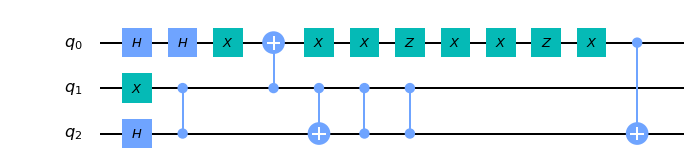

In [16]:
qc3 = QuantumCircuit(3)
qc3.h(0)
qc3.x(1)
qc3.h(2)
qc3.cz(2,1)
qc3.h(0)
qc3.x(0)
qc3.cx(1,0)
qc3.x(0)
qc3.x(0)
qc3.z(0)
qc3.x(0)
qc3.cx(1,2)
qc3.x(0)
qc3.z(0)
qc3.x(0)
qc3.cz(1,2)
qc3.cz(2,1)
qc3.cx(0,2)
qc3.draw('mpl')

If we directly compile this circuit without any optimization, each gate will be decomposed individually in terms of separate $R_X$, $R_Z$ and $CZ$ gates. Let's do that by passing the circuit to our `translate1` function with the optimization level set to 0: `op_level = 0`

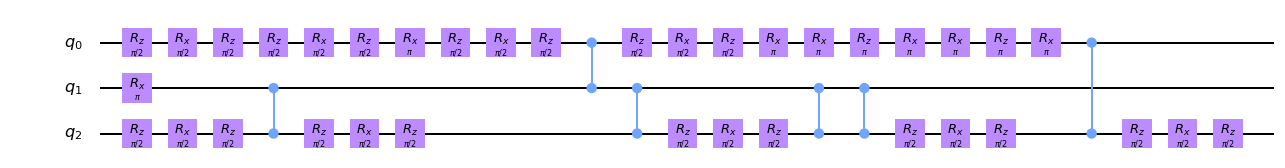

In [17]:
qc3_trans = translate1(qc3, op_level = 0)
qc3_trans.draw(output='mpl', fold = 100)

We can now check the cost of these two circuits and the overhead:

In [18]:
cost_ori = qc_cost(qc3)
cost_trans =  qc_cost(qc3_trans)
overhead = cost_trans - cost_ori
print('Cost of original circuit: {}'.format(cost_ori))
print('Cost of compiled circuit: {}'.format(cost_trans))
print('Overhead: {}'.format(overhead))

Cost of original circuit: 42
Cost of compiled circuit: 66
Overhead: 24


Let's now perform the optimization by setting `op_level = 1`, and check the overhead for the new circuit:

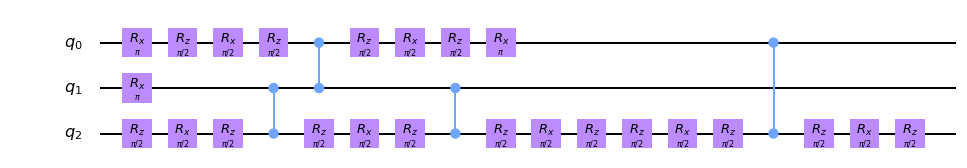

In [19]:
qc3_trans2 = translate1(qc3, op_level = 1)
qc3_trans2.draw(output='mpl', fold = 100)

In [20]:
cost_trans2 =  qc_cost(qc3_trans2)
overhead2 = cost_trans2 - cost_ori
print('Cost of original circuit: {}'.format(cost_ori))
print('Cost of compiled circuit: {}'.format(cost_trans2))
print('Overhead: {}'.format(overhead2))

Cost of original circuit: 42
Cost of compiled circuit: 44
Overhead: 2


As expected, the overhead has been reduced dramatically because the compiler removed redundant gates that result in indentity operations.

Let's also make sure that our compiler did not change the outcome of the circuit by comparing the output statevectors of the original circuit and the translated circuit:

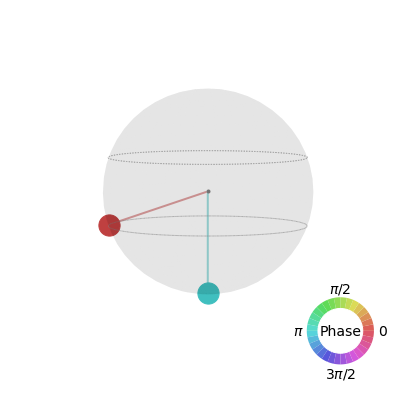

In [21]:
# Qsphere representation of original circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc3).data)

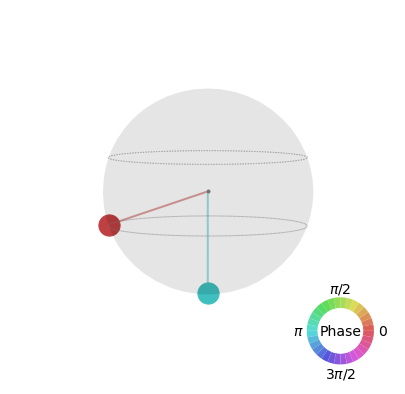

In [22]:
# Qsphere representation of compiled circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc3_trans2).data)

Now, this **level 1** optimization might seem rather trivial or even not very useful; after all, in most scenarios, the designer of a quantum circuit will purposely avoid placing consecutive pairs of these types of gates. However, additional simple identities can be added to this type of optimization to reduce gate counts. For example, an $Z$ in between two Hadamard gates is equivalent to an $X$ gate: $ HZH = X $. Here, we will not do this because the next optimization technique presented below (**level 2**) will help us get closer to a method to reduce these type of identities in a much more general and efficient way.


## 5. Optimization - Level 2 <a id="op2"></a>

A better way to perform optimization is by combining sequential rotation gates of the same kind after the circuit has been translated into the $R_X, R_Z, CZ$ basis set. This will not only remove gates of the same kind, but will also combine gates corresponding to rotations about the same axis. For example: the following to sequential gates $R_X(\pi/2) R_X(\pi/4) $ can be comibined into a single gate by adding the angles of rotation: $R_X(3\pi/4)$. The code below is a modified version of `optimize1` that achieves this purpose:

In [23]:
def optimize2(qc_ori):
        
    qc_red = qc_ori.copy()                                # Create copy of original circuit
    a = 1
    b = len(qc_red.data)
    reducible = ['RXGate', 'RZGate']                      # List of 1-qubit reducible gates
    twoqubitgt = ['CXGate', 'CZGate']                     # List of 2-qubit gates

    while a < b:
        gate_type1 = type(qc_red.data[a-1][0]).__name__   # Type of current gate

        """Check if gate is in list of 1-qubit reducible gates, and find if adjacent gate is of same type"""
        if gate_type1 in reducible:
            gate_qb1 = qc_red.data[a-1][1][0].index             # qubit number of current gate
            gate_ang1 = qc_red.data[a-1][0].params[0]           # angle of rotation of current gate

            mtch_flg = False
            j = a
            gate_qb2b = None

            while not mtch_flg:
                gate_type2 = type(qc_red.data[j][0]).__name__   # Type of gate being compared
                gate_qb2a = qc_red.data[j][1][0].index          # qubit number of gate being compared

                if gate_type2 in twoqubitgt:                    # Check qubit connections of 2-qubit gates
                    gate_qb2b = qc_red.data[j][1][1].index
                else:
                    gate_qb2b = None

                if (gate_qb2a == gate_qb1) or (gate_qb2b == gate_qb1):
                    if gate_type2 == gate_type1:
                        """Add up rotation angles and remove one of the gates.
                           If sum of angles is 0, remove both gates"""
                        gate_ang2 = qc_red.data[j][0].params[0]         # angle of rotation of gate being compared
                        ang_sum = gate_ang2 + gate_ang1
                        qc_red.data[j][0].params[0] = ang_sum
                        
                        """If angle is multiple of 2*pi, remove gate"""
                        if ((ang_sum/(2*np.pi)) % 1) == 0:
                            qc_red.data.pop(j)
                        
                        qc_red.data.pop(a-1)
                        a = 1
                        b = len(qc_red.data)
                        
                    else:
                        a+=1

                    mtch_flg = True

                elif j < b-1:
                    j+=1
                else:
                    a+=1
                    mtch_flg = True
                    
        elif gate_type1 == 'CZGate':
            """Check if gate is CZGate, and find if adjacent gate is of same type"""
            gate_qb1a = qc_red.data[a-1][1][0].index             # qubit number of control
            gate_qb1b = qc_red.data[a-1][1][1].index             # qubit number of target

            mtch_flg = False
            j = a
            gate_qb2b = None

            while not mtch_flg:
                gate_type2 = type(qc_red.data[j][0]).__name__   # Type of gate being compared
                gate_qb2a = qc_red.data[j][1][0].index          # first qubit gate being compared

                if gate_type2 in twoqubitgt:                    # Check qubit connections of 2-qubit gates
                    gate_qb2b = qc_red.data[j][1][1].index
                else:
                    gate_qb2b = None

                if (gate_qb2a == gate_qb1a) or (gate_qb2b == gate_qb1a):
                    if (gate_type2 == gate_type1 == 'CZGate') and (((gate_qb2a == gate_qb1b) and (gate_qb2b == gate_qb1a)) or ((gate_qb2a == gate_qb1a) and (gate_qb2b == gate_qb1b))):
                        """Check for adjacent CZ gates with matching or opposite qubits"""
                        qc_red.data.pop(j)
                        qc_red.data.pop(a-1)
                        b = len(qc_red.data)
                        a = 1
                    else:
                        a+=1

                    mtch_flg = True

                elif j < b-1:
                    j+=1
                else:
                    a+=1
                    mtch_flg = True

        elif gate_type1 == 'HGate':
            """Check if gate is HGate, and find if adjacent gate is of same type"""
            gate_qb1 = qc_red.data[a-1][1][0].index             # qubit number of current gate

            mtch_flg = False
            j = a
            gate_qb2b = None

            while not mtch_flg:
                gate_type2 = type(qc_red.data[j][0]).__name__   # Type of gate being compared
                gate_qb2a = qc_red.data[j][1][0].index          # qubit number of gate being compared

                if gate_type2 in twoqubitgt:                    # Check qubit connections of 2-qubit gates
                    gate_qb2b = qc_red.data[j][1][1].index
                else:
                    gate_qb2b = None

                if (gate_qb2a == gate_qb1) or (gate_qb2b == gate_qb1):
                    if gate_type2 == gate_type1:
                        """Remove adjancent gates, get new length of circuit"""
                        qc_red.data.pop(j)
                        qc_red.data.pop(a-1)
                        b = len(qc_red.data)
                        a = 1
                    else:
                        a+=1

                    mtch_flg = True

                elif j < b-1:
                    j+=1
                else:
                    a+=1
                    mtch_flg = True            
            
        else:
            a += 1
            
    return qc_red

We can now upgrade our compiler function to include this optimization:

In [24]:
def translate2(qc_ori, trans_id = False, op_level = 0):
    
    if op_level == 2:
        qc_trans2 = translate0(qc_ori, trans_id)
        qc_trans = optimize2(qc_trans2)
    
    elif op_level == 1:
        qc_trans1 = optimize1(qc_ori)
        qc_trans = translate0(qc_trans1, trans_id)
    
    elif op_level == 0:
        qc_trans = translate0(qc_ori, trans_id)

    else:
        raise Exception('Optimization level must be 0, 1 or 2')    
        
    return qc_trans

### Example 4 <a id="ex4"></a>

Let's now create a new circuit composed of all allowable gates to showcase the different levels of optimization:

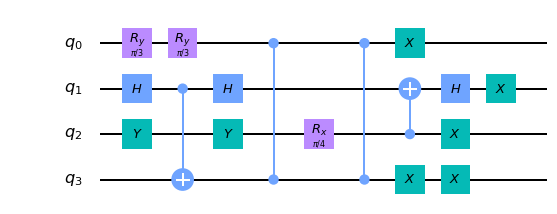

In [25]:
qc4 = QuantumCircuit(4)
qc4.ry(np.pi/3,0)
qc4.ry(np.pi/3,0)
qc4.h(1)
qc4.cx(1,3)
qc4.cz(3,0)
qc4.y(2)
qc4.y(2)
qc4.cz(0,3)
qc4.rx(np.pi/4,2)
qc4.h(1)
qc4.cx(2,1)
qc4.h(1)
qc4.x(3)
qc4.x(range(4))
qc4.draw('mpl')

In [26]:
cost_ori =  qc_cost(qc4)
print("cost of starting circuit: {}".format(cost_ori))

cost of starting circuit: 33


Without optimization:

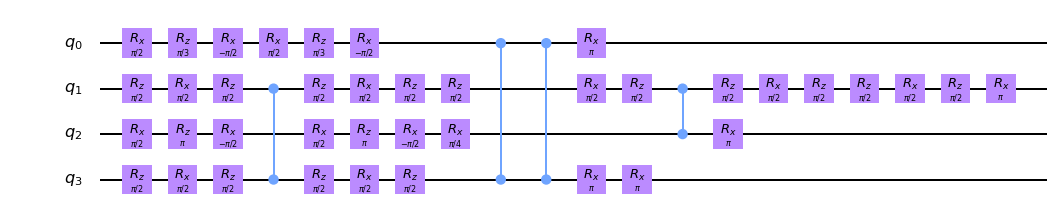

In [27]:
qc4_trans0 = translate2(qc4, op_level = 0)
qc4_trans0.draw('mpl')

In [28]:
cost_trans0 = qc_cost(qc4_trans0)
overhead0 = cost_trans0 - cost_ori
print("cost after compiling without optimization: {}".format(cost_trans0))
print("Overhead without optimization: {}".format(overhead0))

cost after compiling without optimization: 59
Overhead without optimization: 26


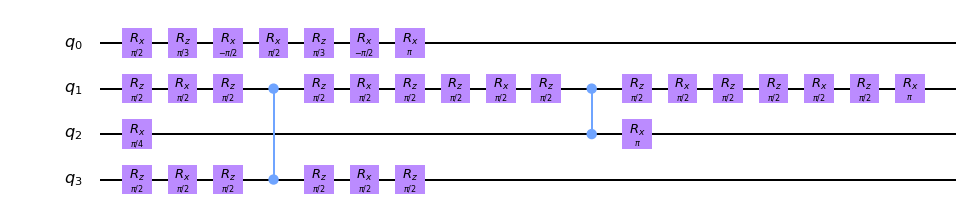

In [29]:
qc4_trans1 = translate2(qc4, op_level = 1)
qc4_trans1.draw('mpl')

In [30]:
cost_trans1 = qc_cost(qc4_trans1)
overhead1 = cost_trans1 - cost_ori
print("cost after optimization Level 1: {}".format(cost_trans1))
print("Overhead optimization Level 1: {}".format(overhead1))

cost after optimization Level 1: 41
Overhead optimization Level 1: 8


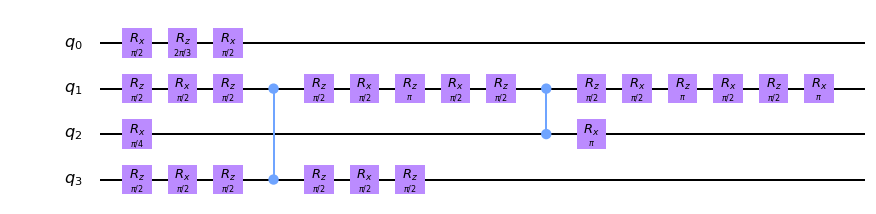

In [31]:
qc4_trans2 = translate2(qc4, op_level = 2)
qc4_trans2.draw('mpl')

In [32]:
cost_trans2 = qc_cost(qc4_trans2)
overhead2 = cost_trans2 - cost_ori
print("cost after optimization Level 2: {}".format(cost_trans2))
print("Overhead optimization Level 2: {}".format(overhead2))

cost after optimization Level 2: 35
Overhead optimization Level 2: 2


Now let's make sure our compiler didn't affect the outcome of our output state after applying our optimization:

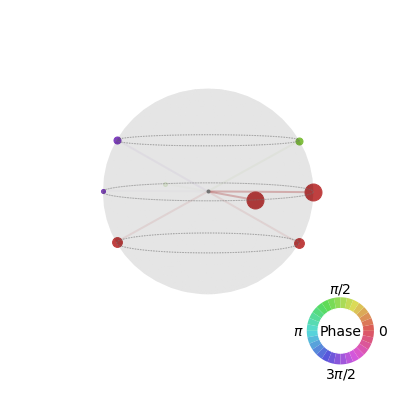

In [33]:
# Qsphere representation of original circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc4).data)

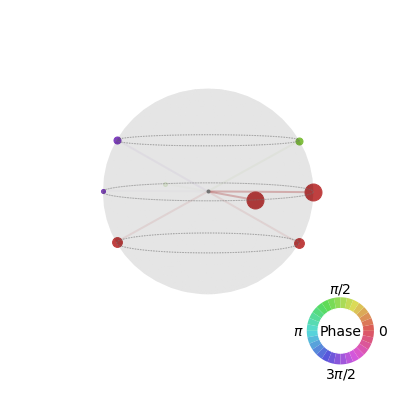

In [34]:
# Qsphere representation of compiled circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc4_trans2).data)

## 6. Optimization - Level 3 <a id="op3"></a>

One of the issues with the `optimization2` function is that it doesn't remove Hadamard identities. Since in this optimization we first convert gates to the $R_X$, $R_Z$, $CZ$ basis, two sequential Hadamard gates result in:

$
\begin{align}
HH &= \begin{pmatrix} R_Z(\pi/2) R_X(\pi/2) R_Z(\pi/2) \end{pmatrix} \begin{pmatrix} R_Z(\pi/2) R_X(\pi/2) R_Z(\pi/2) \end{pmatrix}
\\
\\
&= R_Z(\pi/2) R_X(\pi/2) R_Z(\pi) R_X(\pi/2) R_Z(\pi/2)
\end{align}
$

which consists of a sequence of five interleaved $R_X$ and $R_Z$ gates, and therefore, results in only one gate reduction, rather than six. This can be resolved by doing the decomposition and optimization by layers: 
1. Translate all gates to the basis set $R_X$, $R_Z$, $H$, $CZ$, 
2. Perform optimization by combining gates in this set
3. Translate $H$ gates to $R_X$, $R_Z$ gates
4. Perform another round of optimization

The `translate3` function below incorporates all different levels of optimization:

In [35]:
def translate3(qc_ori, trans_id = False, op_level = 0):

    if op_level == 3:
        qc_trans3a = translate0(qc_ori, trans_id, keep_H = True)
        qc_trans3b = optimize2(qc_trans3a)
        qc_trans3c = translate0(qc_trans3b, trans_id, keep_H = False)
        qc_trans = optimize2(qc_trans3c)        
    
    elif op_level == 2:
        qc_trans2 = translate0(qc_ori, trans_id)
        qc_trans = optimize2(qc_trans2)
    
    elif op_level == 1:
        qc_trans1 = optimize1(qc_ori)
        qc_trans = translate0(qc_trans1, trans_id)
    
    elif op_level == 0:
        qc_trans = translate0(qc_ori, trans_id)

    else:
        raise Exception('Optimization level must be 0, 1, 2 or 3')    
        
    return qc_trans

Let's now run the circuit from example 4 and evaluate the cost:

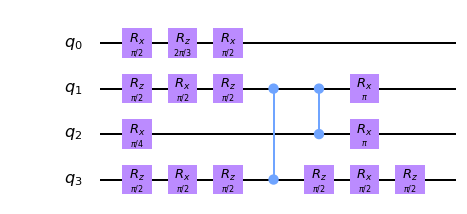

In [36]:
qc4_trans3 = translate3(qc4, op_level = 3)
qc4_trans3.draw('mpl')

In [37]:
cost_trans3 = qc_cost(qc4_trans3)
overhead3 = cost_trans3 - cost_ori
print("cost after optimization Level 3: {}".format(cost_trans3))
print("Overhead optimization Level 3: {}".format(overhead3))

cost after optimization Level 3: 25
Overhead optimization Level 3: -8


As can be seen, this results in a significant improvement with respect to the previous optimization levels. And just to make sure the compiler didn't change the overall function of our circuit, let's once again look at the output state vector:

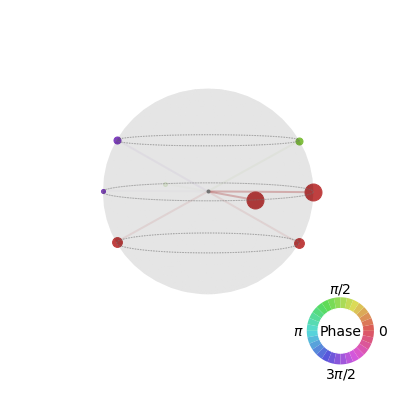

In [38]:
# Qsphere representation of compiled circuit
plot_state_qsphere(qi.Statevector.from_instruction(qc4_trans2).data)

## 7. Final Notes <a id="final"></a>

It is important to note that the way the translation and optimization functions implemented herein are not very efficient. This is because I opted to perform every operation by accessing the `instruction` of every circuit by using the `.data` method of each `QuantumCircuit`. The problem with this approach is that, the information we get access to is an unorganized netlist of gates, so every time we need to perform a translation or a reduction, the whole list needs to be searched to find adjacent gates that could be potentially reduced. I decided to do things this way to avoid the usage of more sophisticated Qiskit functions (as described below), or reusing code from what Qiskit has implemented for their own transpiler.

Now, a more efficient way to scan and optimize circuits in Qiskit is by translating the circuit `instruction` into a [directed acyclic graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) (DAG) by using the [`circuit_to_dag`](https://qiskit.org/documentation/stubs/qiskit.converters.circuit_to_dag.html) function. This is actually the way Qiskit's `transpiler` manipulates circuits to perform different types of passes. A DAG is advantageous because it is structured in a way in which the direct connection between gates for a given register is explicit. 

Lastly, it is important to note that more sophisticated optimizations for cost reduction can be implemented, in particular by the introduction of dummy 2-qubit gates. For example, by introducing pairs of dummy Hadamard gates before and after the target qubit of $CX$ gates allows us to swap the control and target qubits in order to combine rotation gates that were originally operating on different qubits.

In [39]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}